<style>
.tit { 
    text-align: left; 
    font-family: Arial Black; 
    font-weight: bold; 
    font-size: 50px; 
    color: #06cc70; 
    text-shadow: -1px 0 #000, 0 1px #000, 3px 0 #000, 0 -1px #000;
}
</style>

<h1 class="tit">Data collection</h1>

#### **Information regarding this notebook**


The data collection process is a set of techniques and methods used to collect, extract, retrieve and store useful information for a specific purpose. This process is critical for a wide range of applications, including data analytics, artificial intelligence, and machine learning.

The data collection process consists of several steps, including:

**1. Identifying the data source:**

The first step is to identify where the data you want to collect is located. Data sources can include databases, files, web pages, and other online sources.

**2. Connection to the data source:** 

Once the data source has been identified, the necessary connections must be established to access the data.

**3. Data Extraction:** 

Once the data source is accessed, the data needed for the specific purpose must be extracted.

**4. Data cleaning and transformation:**

The extracted data may contain errors, duplicates or irrelevant information. Therefore, it is necessary to clean and transform the data to ensure that it is accurate and useful for further analysis.

**5. Data storage:**

Finally, the clean and transformed data must be stored in a suitable format for later use.

In general, the data collection process is a critical step in data analysis and informed decision making. Therefore, it is important to ensure that the data is accurate, complete and relevant for the specific purpose.

#### <span style="color:yellow">Load the dependencies used in the notebook</span>

Install packages that are requirements

In [6]:
%pip install -r Demo_requirements.txt

Defaulting to user installation because normal site-packages is not writeable
  Using cached beautifulsoup4-4.11.2-py3-none-any.whl (129 kB)
  Using cached soupsieve-2.4-py3-none-any.whl (37 kB)


**Set environment variables**

In [2]:
# Set up the environment variables using python
import os
os.environ['LIBRARIES_API_KEY'] = 'dcc8a237b15dac0e6334df54bd9573fb'

**Import libraries**

In [3]:
# Import modules
import os
import warnings
import datetime
import pickle
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from bs4 import BeautifulSoup
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
from pybraries import Search   

# Own modules
from modules.scraping.ProxyRequest import RequestHandler
from modules.scraping.CranScraper import CranScraper
from modules.Package import Package
from modules.Util import *
from modules.db.ORM_Model import *

# <ins>**1 - Using datasets**</ins>

## **1.1 - Data from libraries.io**

### **1.1.0 - Previous notes (about libraries.io):**

<a href="https://libraries.io/">Libraries.io</a> is a platform that tracks and aggregates information about open source projects and software packages. 

Provides an overview of projects and packages, including information about their dependencies, development status, licenses, and supported platforms. This information can be useful for developers who are looking for specific projects and packages to include in their projects, or for those who simply want to explore the different options available. 

Furthermore, Libraries.io also allows users to monitor and receive notifications about changes and updates to specific projects and packages.

Taking into account the material provided by <a href="https://libraries.io/">libraries.io</a> as a source of information, a series of functions have been implemented to extract the data.
Libraries.io provides us with a compressed file that contains a series of datasets in csv format, each one of them contains the data referring to a standard classification, specifically and according to the documentation:

Libraries.io's data is organised into seven packages.

| Term | Definition |
| --- | --- |
| Projects | A Libraries.io project is the definition of a package available from one of the 32 Package Managers that it supports. |
| Versions | A Libraries.io version is a definition of an immutable published version of a Project from a package manager. Not all package managers have a concept of publishing versions, often relying directly on tags/branches from a source control. |
| Tags | A Libraries.io tag is equivalent to a tag in git or other source control systems. |
| Dependencies | Libraries.io dependencies belong to versions of a project, each version can have different sets of dependencies with different versions. Dependencies point at a specific version or range of versions of other projects, the resolution of that project version change over time as new versions are published and dependent on the specifics of the platform. Almost all package managers dependencies will be from the same package manager, although the extra `Dependency Platform` field exists otherwise. |
| Repositories | A Libraries.io repository represents a publically accessible source code repository from either github.com, gitlab.com or bitbucket.org. |
| Repository Dependencies | A Libraries.io repository dependency is where a dependency on a Project from a package manager has been specified in a manifest file, either as a manually added dependency committed by a user or listed as a generated dependency listed in a lockfile that has been automatically generated by a package manager and commited. |
| Projects with related Repository fields | This is an alternative projects export that denormalizes a projects related source code repository inline to reduce the need to join between two data sets. |

We can download the data from the following url:

- https://zenodo.org/record/3626071/files/libraries-1.6.0-2020-01-12.tar.gz 

### **1.1.1 - Introduction**

<style>
.green {color: green;}
</style>
**Packages**

In relation to the previous note, for the analysis of the network of package dependencies in software repositories.

We are going to focus on the information provided by the Projects file <span class="green">projects-1.6.0-2020-01-12.csv</span>, where we can find information regarding the package and its metadata.

It has the following structure:

| Field Name | Data Type | Description |
| --- | --- | --- |
| ID  | integer | The unique primary key of the project in the Libraries.io database |
| Platform | string | The name of the Package manager the project is available on. |
| Name | string | The name of the project, unique by Platform (case sensitive). |
| Created Timestamp | datetime | The timestamp of when Libraries.io first discovered the project. |
| Updated Timestamp | datetime | The timestamp of when Libraries.io last saved a change to the project. |
| Description | string | Description provided by the package manager, falling back to description from repository if empty. |
| Keywords | string | Comma separated array of keywords if supported by package manager. |
| Homepage URL | string | URL of webpage or repository as provided by package managers that support it. |
| Licenses | string | Comma separated array of SPDX identifiers for licenses declared in package manager meta data or submitted manually by Libraries.io user via "project suggestion" feature. |
| Repository URL | string | URL of source code repository declared in package manager metadata or submitted manually by Libraries.io user via "project suggestion" feature. |
| Versions Count | integer | Number of published versions of the project found by Libraries.io. |
| SourceRank | integer | Libraries.io defined score based on quality, popularity and community metrics. |
| Latest Release Publish Timestamp | datetime | Time of the latest release detected by Libraries.io (ordered by semver, falling back to publish date for invalid semver). |
| Latest Release Number | string | Version number of the latest release detected by Libraries.io (ordered by semver, falling back to publish date for invalid semver). |
| Package Manager ID | integer | Unique ID of project from package manager API. |
| Dependent Projects Count | integer | Number of other projects that declare the project as a dependency in one or more of their versions. |
| Language | string | Primary programming language the project is written in, pulled from the repository if source is hosted on GitHub. |
| Status | string | The current status of the project, as determined by Libraries.io |

**Dependencies**

The dependencies file contains information about the dependencies of the packages, according to the documentation:

- Libraries.io dependencies belong to versions of a project, each version can have different sets of dependencies with different versions. Dependencies point at a specific version or range of versions of other projects, the resolution of that project version change over time as new versions are published and dependent on the specifics of the platform.

- Almost all package managers dependencies will be from the same package manager, although the extra `Dependency Platform` field exists otherwise

|Field|Type|Description|
|---|---|---|
|ID|integer|The unique primary key of the dependency in the Libraries.io database|
|Platform|string|The name of the package manager on which the dependency is available|
|Project Name|string|The name of the project the dependency belongs to|
|Project ID|integer|The project's unique primary key for this dependency in the Libraries.io database|
|Version Number|string|The version number to which the dependency belongs|
|Version ID|integer|The version's unique primary key for this dependency in the Libraries.io database|
|Dependency Name|string|The name of the project that specifies the dependency|
|Dependency Platform|string|The name of the package manager from which the project specifying the dependency is available|
|Dependency Kind|string|The kind of dependency, often declared for the use phase, eg runtime, test, develop, compile.|
|Optional Dependency|boolean|Is the dependency optional?|
|Dependency Requirements|string|The version or range of versions that the dependency specifies, the resolution of that specific version is specific to the package manager.|
|Dependency Project ID|integer|The unique project primary key for this dependency in the Libraries.io database|

### **1.1.2 - Data filtering**

#### Packages

Since this Notebook is focused on CRAN as a proof of concept and due to the large file size, we have isolated the CRAN data in a new dataset.

We generate a new csv that will contain only the CRAN data

**Note:** 

The file <kbd>'projects-1.6.0-2020-01-12.csv'</kbd> is very large, for this reason it is not included in the repository, you can download the data from the link provided above

We leave the code commented so as not to carry out this process every time the notebook is executed


In [2]:
# # # Read the csv file and extract the data with column 'Platform' = 'CRAN' to a new dataframe
# path = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12/'
# packages_df = pd.read_csv(path + 'projects-1.6.0-2020-01-12.csv')
# packages_df = packages_df[packages_df['Platform'] == 'CRAN']

# # Save the new dataframe to a csv file
# packages_df.to_csv('data/projects-1.6.0-2020-01-12-cran.csv', index=False)

/tmp/ipykernel_11136/1172569731.py:3: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  packages_df = pd.read_csv(path + 'projects-1.6.0-2020-01-12.csv')


Finally we visualize the generated csv

In [13]:
# Read the csv file generated from the previous step
packages_df = pd.read_csv('data/projects-1.6.0-2020-01-12-cran.csv')
packages_df.head(2)

,ID,Platform,Name,Created Timestamp,Updated Timestamp,Description,Keywords,Homepage URL,Licenses,Repository URL,...,SourceRank,Latest Release Publish Timestamp,Latest Release Number,Package Manager ID,Dependent Projects Count,Language,Status,Last synced Timestamp,Dependent Repositories Count,Repository ID
0,687281,CRAN,archivist,2015-03-02 00:48:14 UTC,2019-10-11 14:26:28 UTC,"Tools for Storing, Restoring and Searching for...",NaN,https://pbiecek.github.io/archivist/,GPL-2.0,https://github.com/pbiecek/archivist,...,14,2019-08-31 00:00:00 UTC,2.3.4,NaN,6,HTML,NaN,2019-10-11 14:26:25 UTC,12,339318.0
1,687282,CRAN,ggthemes,2015-03-02 00:48:15 UTC,2019-05-13 09:52:57 UTC,"Extra Themes, Scales and Geoms for 'ggplot2'",NaN,http://github.com/jrnold/ggthemes,GPL-2.0,https://github.com/jrnold/ggthemes,...,19,2019-05-13 00:00:00 UTC,4.2.0,NaN,64,R,NaN,2019-05-13 09:52:55 UTC,232,339319.0


We can see that in total we have 16695 packages in the CRAN csv

In [4]:
# Contar el número de proyectos en el dataframe
packages_df.shape

(16695, 21)

As an example, let's get the data of the A3 package

In [5]:
# Get the A3 package data from the df dataframe
packages_df[packages_df['Name'] == 'A3']

,ID,Platform,Name,Created Timestamp,Updated Timestamp,Description,Keywords,Homepage URL,Licenses,Repository URL,...,SourceRank,Latest Release Publish Timestamp,Latest Release Number,Package Manager ID,Dependent Projects Count,Language,Status,Last synced Timestamp,Dependent Repositories Count,Repository ID
5143,692488,CRAN,A3,2015-03-02 01:14:48 UTC,2019-10-11 17:58:17 UTC,"Accurate, Adaptable, and Accessible Error Metr...",NaN,NaN,"CNRI-Python-GPL-Compatible,CNRI-Python-GPL-Com...",NaN,...,5,2015-08-16 00:00:00 UTC,1.0.0,NaN,0,NaN,NaN,2019-10-11 17:58:17 UTC,0,NaN


#### Dependencies

As before, we are going to extract this information from the dependencies file

In [8]:
path = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12'
dependencies_df = pd.read_csv(path + os.sep + 'dependencies-1.6.0-2020-01-12.csv', nrows=5)

In [9]:
dependencies_df.head(2)

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
0,8737,Dub,a4g,197,0.1.0,2,a4g:client,Dub,runtime,False,*,NaN
1,8738,Dub,a4g,197,0.1.0,2,a4g:server,Dub,runtime,False,*,NaN


This file is very large and the machine I have does not have enough RAM to open it, so the only solution is to cut it into smaller pieces.

In a linux system we can use the following command to split the file into files of 10000 lines each

In [5]:
#!cat dependencies-1.6.0-2020-01-12.csv | parallel --header : --pipe -N10000 'cat >dependencies-1.6.0-2020-01-12/split_dependencies-1.6.0-2020-01-12_{#}.csv'

We can see that the file has been divided into 19040 smaller files.

In [7]:
## Count the number of files in the directory
PATH_ = '/media/dnllns/Externo/libraries_data/libraries-1.6.0-2020-01-12/' 
!ls -l $PATH_"dependencies-1.6.0-2020-01-12" | wc -l

19040


In [10]:

warnings.filterwarnings("ignore", category=FutureWarning)


file_count = 0
dependencies_df = pd.DataFrame()
files = os.listdir(path + os.sep + 'dependencies-1.6.0-2020-01-12')

# Procesar los archivos de dependencias
# Si la fila tiene un valor 'CRAN' en la columna 'Dependency Platform', se guarda en un nuevo dataframe
pbar = tqdm(total=len(files))
for file in files:
    if file.endswith(".csv"):
        file_count += 1
        temp_dependencies_df = pd.read_csv(path + os.sep + 'dependencies-1.6.0-2020-01-12/' + file)
        dependencies_df = pd.concat([dependencies_df, temp_dependencies_df[temp_dependencies_df['Dependency Platform'] == 'CRAN']])
    pbar.update(1)
pbar.close()

dependencies_df.to_csv('data' + os.sep + 'dependencies-1.6.0-2020-01-12-cran.csv', index=False)

100%|██████████| 19039/19039 [1:12:52<00:00,  4.35it/s]    


Once all the files have been processed we have a csv that contains the dependencies of the CRAN packages.


We will show the dependencies of the A3 package of type imports and depends for version 1.0.0

In [11]:
dependencies_df = pd.read_csv('data/dependencies-1.6.0-2020-01-12-cran.csv')

# Obtener la ultima version de la libreria A3 y guardarla en una variable
last_version =  dependencies_df[dependencies_df['Project Name'] == 'A3'].sort_values(by=['Version Number'], ascending=False).head(1)['Version Number'].values[0]

# Show the dependencies of the last version of A3 package y and the field (Dependency Kind) is 'depends' or 'imports'
dependencies_df[(dependencies_df['Project Name'] == 'A3') & (dependencies_df['Version Number'] == last_version) & (dependencies_df['Dependency Kind'].isin(['depends', 'imports']))]

,ID,Platform,Project Name,Project ID,Version Number,Version ID,Dependency Name,Dependency Platform,Dependency Kind,Optional Dependency,Dependency Requirements,Dependency Project ID
233050,29214218,CRAN,A3,692488,1.0.0,3549070,R,CRAN,depends,False,>= 2.15.0,NaN


In [21]:
# Obtener un set con los distintos nombres de las librerias
dependency_packages = set(dependencies_df['Dependency Name'].values)
packages_with_dependencies = set(dependencies_df['Project Name'].values)
total_packages = set(packages_df['Name'].values)
packages_without_dependencies = total_packages - packages_with_dependencies

# Total number of packages (csv of projects)
print('Total packages: ', len(total_packages))
print('Total packages with dependencies : ', len(dependency_packages | packages_with_dependencies))
print('Total packages that are dependencies of others: ', len(dependency_packages))
print('Total packages without dependencies: ', len(packages_without_dependencies))

Total packages:  16695
Total packages with dependencies :  16174
Total packages that are dependencies of others:  5501
Total packages without dependencies:  1173


We build a histogram to represent the analyzed information

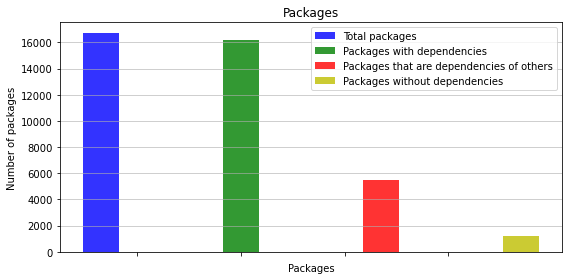

In [23]:
# Data to plot as a histogram
data1 = [len(total_packages), 0, 0, 0]
data2 = [0, len(dependency_packages | packages_with_dependencies), 0, 0]
data3 = [0, 0, len(dependency_packages), 0]
data4 = [0, 0, 0, len(packages_without_dependencies)]

fig, ax = plt.subplots(figsize=(8, 4))
index = np.arange(4)
bar_width = 0.35
opacity = 0.8
rects1 = plt.bar(index, data1, bar_width, alpha=opacity, color='b', label='Total packages')
rects2 = plt.bar(index+bar_width, data2, bar_width, alpha=opacity, color='g', label='Packages with dependencies')
rects3 = plt.bar(index+2*bar_width, data3, bar_width, alpha=opacity, color='r', label='Packages that are dependencies of others')
rects4 = plt.bar(index+3*bar_width, data4, bar_width, alpha=opacity, color='y', label='Packages without dependencies')
plt.xlabel('Packages')
plt.ylabel('Number of packages')
plt.title('Packages')
plt.xticks(index + bar_width, ())

# Add a grid    
plt.grid(axis='y', alpha=0.75)
ax.legend(loc='upper right')
plt.tight_layout()
plt.show()


---

# <ins>**2 - Web Scraping**</ins>

## **2.0 - Previous notes (about the web scraping technique):**

Web scraping is a technique for extracting data from web pages in order to obtain information for further analysis. It is done through the use of software programs that automate the task of browsing web pages and extracting specific information.

Advantages of this technique include the ability to collect large amounts of data in a short period of time, accessibility to otherwise difficult-to-obtain information, and the ability to perform real-time data analysis.

However, there are also drawbacks, such as the lack of guarantee of the accuracy and timeliness of the information obtained, the possibility of violating the privacy and security policies of websites, and the illegality of the technique in some cases.

In the case where the information is not available in dataset format or in some other way, web scraping becomes a useful tool to extract such information from web pages. However, it is important to note that the information extracted may not be accurate or out of date, and that the data extraction may be illegal or violate the privacy and security policies of the websites. Therefore, it is important to carefully assess the need and potential impact before taking any web scraping action.

## **2.1 - Implementation Details**

**ProxyRequest module**

To carry out the task of obtaining data through web scraping, the module <span style="color:green; font-weight:bold">ProxyRequest</span> with the class <span style="color:green; font-weight:bold">RequestHandler</span> has been implemented to make the operation more transparent.


The RequestHandler module allows us to make requests using different *proxies and useragents* with the aim of avoiding the denial of service by the server to our requests, which will happen if or if due to their high number.

The implementation of the class is not defined in this notebook due to not extending the contents much.

You can see the implementation of the module and more information at:

- https://github.com/dab0012/olivia/blob/master/Demo/modules/scraping/ProxyRequest.py



**CranScraper module**

This module has been implemented with the objective of extracting the information of the packages housed on the Cran website.

This website contains a list of packages currently dissipable in Cran, as well as the packages that have been filed (orphanage or by express desire for the maintainer)

The <span style="color:green; font-weight:bold">CranScraper</span> class implemented in this module allows us to extract the information stored in the HTML and process it with the aim of generating an object of the package class that we have previously implemented.

You can see the implementation of the module in the next URL:

- https://github.com/dab0012/olivia/blob/master/Demo/modules/scraping/CranScraper.py

## **2.2 - Scraping process**

### Package processing

We do a test getting a package

In [2]:
cran_scraper = CranScraper(RequestHandler())        # Create object of class CranScraper
p = cran_scraper.pkg_builder('MASS')                # Get the MASS package data
p.dump()                                            # Print the package data                     

Request failed as Exception:
Exception getting package MASS: local variable 'proxy' referenced before assignment
Exception parsing dependencies of package MASS: 'NoneType' object has no attribute 'get'
Exception parsing dependencies of package MASS: 'NoneType' object has no attribute 'get'


TypeError: 'NoneType' object is not subscriptable

### Scraping CRAN website

Once all the tools have been obtained, the only thing left is to obtain the information of each of the packages.

#### Get a list of packages

In [12]:
packages = []

We make a request to the CRAN web server and get the list of packages

In [13]:
# URL to get the list of packages from CRAN
CRAN_pkgs_url = "https://cran.r-project.org/web/packages/available_packages_by_name.html"

# Create object of class RequestHandler
rh = RequestHandler()

# Do the request
response = rh.do_request(CRAN_pkgs_url, retry=True)

# If the request was successful
if response.status_code == 200:
    print("Request successful")
else:
    print("Error in request")

Request successful


If the request was correct, we will begin to extract the information we need

We will use the BeautifullSoup4 library to do the scraping

In [14]:
# We parse the HTML content of the web page using BeautifulSoup
# We extract the table that contains the information of the CRAN packages
soup = BeautifulSoup(response.content, "html.parser")
table = soup.find("table")
rows = table.find_all("tr")

As you can see we have the information stored in a table, now we iterate each row to extract the name of the packages

In [15]:
rows[:5]

[<tr id="available-packages-A"> <td></td> </tr>,
 <tr>
 <td><a href="../../web/packages/A3/index.html">A3</a></td><td>Accurate, Adaptable, and Accessible Error Metrics for Predictive
 Models</td></tr>,
 <tr>
 <td><a href="../../web/packages/AATtools/index.html">AATtools</a></td><td>Reliability and Scoring Routines for the Approach-Avoidance Task</td></tr>,
 <tr>
 <td><a href="../../web/packages/ABACUS/index.html">ABACUS</a></td><td>Apps Based Activities for Communicating and Understanding
 Statistics</td></tr>,
 <tr>
 <td><a href="../../web/packages/abbreviate/index.html">abbreviate</a></td><td>Readable String Abbreviation</td></tr>]

The data could be pre-processed to remove unwanted debris, although we will handle this later.

In [16]:
rows[0]

<tr id="available-packages-A"> <td></td> </tr>

In [17]:
rows.pop(0)

<tr id="available-packages-A"> <td></td> </tr>

We import the Packages module, whose implementation is documented in the 'Data storage and Persistence' notebook

We also import the Util module, which contains code to garnish the stdout output (Nothing relevant)

In [ ]:
# We iterate over each row of the table
for row in rows:

    # We extract the cells of the current row
    cells = row.find_all("td")

    package_name = ""
    # If there are cells in the row
    if cells:
        try: 
            # We extract the name of the package
            # The name is in the first cell of the row
            package_name = cells[0].find("a").text   

            # We add the package name to the list of packages
            packages.append(package_name)

            # Show success message
            message = "Package " + package_name + " added to the list"
            print_colored(message, GREEN)
            

        # If an error occurs, we show the error message
        except Exception as e:
            
            # message string
            message = "Error processing package: " + package_name
            message += "Exception: " + e.__class__.__name__ 
            message += "Error: " + str(e)

            # Print error message
            print_colored(message, RED)
            print("Continuing...")

In [21]:
# We show the number of packages that we have processed
print("Number of packages processed: ", len(packages))

Number of packages processed:  19231


We can store the list of packages in a file so as not to repeat this step more times unless we want to update

In [22]:
# We open the file in write mode
timestampe = datetime.datetime.now().strftime("%Y%m%d%H%M%S")
file_name = "data" + os.sep + "packages_" + timestampe + ".pkl"
with open(file_name, "wb") as f:
    # We dump the packages list in the file
    pickle.dump(packages, f)


Check that the package file has been properly generated

In [23]:
os.listdir("data")

['dependencies-1.6.0-2020-01-12-cran.csv',
 'packages_20230221121430.pkl',
 'projects-1.6.0-2020-01-12-cran.csv']

In [30]:
# Get the latest file pkl packages file stored in the data folder using the file creation date
pkl_package_list = max([f for f in os.listdir("data") if f.endswith(".pkl")], key=lambda x: os.path.getctime(os.path.join("data", x)))
print("Latest file: ", pkl_package_list)

Latest file:  packages_20230221121430.pkl


We are going to show some basic statistics to get a little better idea of ​​the data we have.

In [31]:
# Compare the list of packages obtained by scraping with the list of packages obtained by the libraries.io dataset
# -------------------------------------------------------------------------------------------------------------

# We load the list of packages obtained by scraping
with open("data" + os.sep + pkl_package_list, "rb") as f:
    packages_scraping = pickle.load(f)

# We load the list of packages obtained by the libraries.io dataset, from the csv file
packages_librariesio = pd.read_csv("data" + os.sep + "projects-1.6.0-2020-01-12-cran.csv")

# We get the names of the packages obtained by scraping
packages_scraping_names = set(packages_scraping)

# We get the names of the packages obtained by the libraries.io dataset
packages_librariesio_names = set(packages_librariesio['Name'].values)

# We get the packages that are in the libraries.io dataset, but not in the scraping dataset
packages_librariesio_not_in_scraping = packages_librariesio_names - packages_scraping_names

# We get the packages that are in the scraping dataset, but not in the libraries.io dataset
packages_scraping_not_in_librariesio = packages_scraping_names - packages_librariesio_names

In [32]:
print("Number of packages in the libraries.io dataset: ", len(packages_librariesio_names))
print("Number of packages in the scraping dataset: ", len(packages_scraping_names))
print("Number of packages in the libraries.io dataset, but not in the scraping dataset: ", len(packages_librariesio_not_in_scraping))
print("Number of packages in the scraping dataset, but not in the libraries.io dataset: ", len(packages_scraping_not_in_librariesio))

# We show the number of packages that are in both datasets
print("Number of packages in both datasets: ", len(packages_scraping_names & packages_librariesio_names))

Number of packages in the libraries.io dataset:  16695
Number of packages in the scraping dataset:  19230
Number of packages in the libraries.io dataset, but not in the scraping dataset:  4092
Number of packages in the scraping dataset, but not in the libraries.io dataset:  6627
Number of packages in both datasets:  12603


We create a bar graph

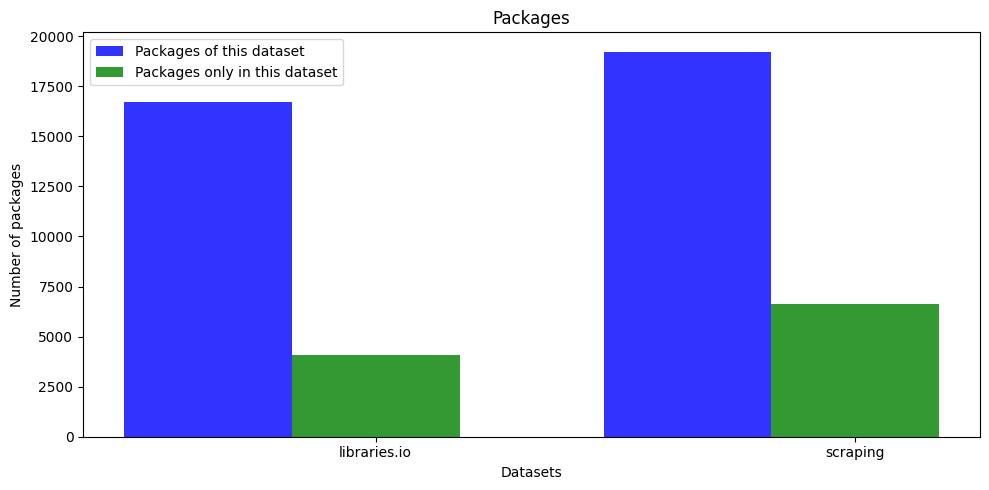

In [33]:
# Graphical representation of the previous results with a bar chart
# ------------------------------------------------------------------

# We create the data to represent in the bar chart
data1 = [len(packages_librariesio_names), len(packages_scraping_names)]
data2 = [len(packages_librariesio_not_in_scraping), len(packages_scraping_not_in_librariesio)]
labels = ["libraries.io", "scraping"]
plt.figure(figsize=(8, 4))
bar_width = 0.35
opacity = 0.8

# We create the bars
index = np.arange(len(labels))
rects1 = plt.bar(index, data1, bar_width, alpha=opacity, color='b', label='Packages of this dataset')
rects2 = plt.bar(index+bar_width, data2, bar_width, alpha=opacity, color='g', label='Packages only in this dataset')

plt.xlabel('Datasets')
plt.ylabel('Number of packages')
plt.title('Packages')
plt.xticks(index + bar_width, labels)
plt.legend()

plt.tight_layout()
plt.show()

#### Scrape packages

The webscraping process is very expensive due to the multiple requests that are going to be made on the server, and the long time that this task requires.


This section has been implemented in such a way that even if the execution of the cell is interrupted, the next time it is executed it will resume the process from the last successfully processed packet

In [5]:
!docker start olivia_mysql
!docker ps -a

olivia_mysql
CONTAINER ID   IMAGE            COMMAND                  CREATED       STATUS                    PORTS                                                  NAMES
1da3f7b9a9f5   mysql:latest     "docker-entrypoint.s…"   5 hours ago   Up Less than a second     0.0.0.0:3306->3306/tcp, :::3306->3306/tcp, 33060/tcp   olivia_mysql
6cdd9865d743   mariadb:latest   "docker-entrypoint.s…"   4 days ago    Exited (0) 23 hours ago                                                          docker_mariadbsso_1


Create a session to interact with the database

In [4]:
db_connector =  "mysql+mysqlconnector"
db_user      =  "root"
db_passwd    =  "olivia"
db_host      =  '172.17.0.2'
db_name      =  "r_network"

# We create the engine
engine = create_engine(db_connector + "://" + db_user + ":" + db_passwd + "@" + db_host + "/" + db_name)

# We create the session
session = sessionmaker(bind=engine)()

We reset the database if necessary

In [3]:
Base.metadata.drop_all(engine)
Base.metadata.create_all(engine)

Get the last package that was inserted into the database

In [4]:
last_package = session.query(Package_MySQL).order_by(Package_MySQL.id.desc()).first()
number_of_packages = session.query(Package_MySQL).count()

print("Last inserted package: ", last_package)
print("Number of packages in the database: ", number_of_packages)

Last inserted package:  None
Number of packages in the database:  0


We get the package list from the pkl file

In [5]:
# Get the latest file pkl packages file stored in the data folder using the file creation date
pkl_package_list = max([f for f in os.listdir("data") if f.endswith(".pkl")], key=lambda x: os.path.getctime(os.path.join("data", x)))
print("Latest file: ", pkl_package_list)

Latest file:  packages_20230221121430.pkl


**Start of scraping process**

First we eliminate all the packages that we have already inserted into the database (fruit of an previous execution) from the package list (fruit of an previous execution)

In [ ]:
# We load the list of packages obtained by scraping
with open("data" + os.sep + pkl_package_list, "rb") as f:
    packages = pickle.load(f)
    
if last_package is not None:

    # Get the index in the list of the last package inserted in db
    # ---------------------------------------------------------------
    last_package_index = packages.index(last_package)
    packages = packages[last_package_index:]

packages

Once we have the list with the packages we have to obtain, we execute the next code and the scraping process begins.

In [ ]:

print("Starting to process packages...")
print("Number of packages: ", len(packages))

scraper = CranScraper(RequestHandler())
for package in packages:

    print_colored("\nProcessing package: " + package, Fore.BLUE)

    # Get the package from the database, If the package is already in the database, dont do anything
    p = Package()
    p.name = package
    if p.build_from_db(session):

        message = "Package already in database: " + package
        message += "\nNumber of packages saved in db: " + str(number_of_packages) + "/" + str(len(packages)) + " (" + str(round(number_of_packages / len(packages) * 100, 2)) + "%)"
        print_colored(message, Fore.YELLOW)
        continue

    # Process the package
    p.in_cran = True
    p = scraper.pkg_builder(package)

    # Save the package in the database
    result = p.save_in_db(session)

    # If the package wasn't saved in the database, Print error message string
    if not result:
        message = "Error saving package: " + p.name
        message += "\nNumber of packages saved in db: " + str(number_of_packages) + "/" + str(len(packages)) + " (" + str(round(number_of_packages / len(packages) * 100, 2)) + "%)"
        print_colored(message, Fore.RED)
        print("Ending program execution")
        session.close()
        exit()

    # If the package was saved in the database, Increment the number of packages in the database
    else:
        number_of_packages += 1
        message = "Package saved: " + p.name
        message += "\nNumber of packages saved in db: " + str(number_of_packages) + "/" + str(len(packages)) + " (" + str(round(number_of_packages / len(packages) * 100, 2)) + "%)"
        print_colored(message, Fore.GREEN)

Once the process is finished we can obtain any Cran package

In [10]:
p = Package("abind")
p.build_from_db(session)
p.dump()

a = 0

Name: abind
Description:
Combine multidimensional arrays into a single array.
  This is a generalization of 'cbind' and 'rbind'.  Works with
  vectors, matrices, and higher-dimensional arrays.  Also
  provides functions 'adrop', 'asub', and 'afill' for manipulating,
  extracting and replacing data in arrays.
Version: 1.4-5
Publication date: 2016-07-21
Mantainer: Tony Plate  <tplate@acm.org>
Authors:
Tony Plate and Richard Heiberger
Dependencies:
  - None
Requires compilation: None
In CRAN: True
In Bioconductor: None
Licenses:
LGPL-2 | LGPL-2.1 | LGPL-3 [expanded from: LGPL (≥ 2)]
Links:
https://cran.r-project.org/package=abind



# <ins>**3 - Libraries.io web API**</ins>

Libraries.io offers us an API through which we can obtain the data referred to the beginning of this notebook.

Unfortunately, if we have no data of the packages in the repository, we cannot obtain any data, since the API requires specifying the name of the package for which we want to obtain information.

We can get more information about the API at:

- https://libraries.io/api

**Basic example of use of the API:**

We get a list of 30 repositories available in *Libraries.io*

In [6]:
api_key = "dcc8a237b15dac0e6334df54bd9573fb"

# make a request to the API
response = requests.get("https://libraries.io/api/platforms?api_key=" + api_key)
print(response.status_code)
print(response.text)

200
[{"name":"NPM","project_count":2881620,"homepage":"https://www.npmjs.com","color":"#f1e05a","default_language":"JavaScript"},{"name":"Pypi","project_count":530242,"homepage":"https://pypi.org/","color":"#3572A5","default_language":"Python"},{"name":"Maven","project_count":525139,"homepage":"http://maven.org","color":"#b07219","default_language":"Java"},{"name":"Go","project_count":439657,"homepage":"https://pkg.go.dev","color":"#375eab","default_language":null},{"name":"NuGet","project_count":419186,"homepage":"https://www.nuget.org","color":"#178600","default_language":"C#"},{"name":"Packagist","project_count":373559,"homepage":"https://packagist.org","color":"#4F5D95","default_language":"PHP"},{"name":"Rubygems","project_count":182768,"homepage":"https://rubygems.org","color":"#701516","default_language":"Ruby"},{"name":"Cargo","project_count":106971,"homepage":"https://crates.io","color":"#dea584","default_language":"Rust"},{"name":"CocoaPods","project_count":92178,"homepage":"h

There is a Python wrapper for the API.

- https://pypi.org/project/pybraries/
- https://pybraries.readthedocs.io/en/latest/stubs/pybraries.search.Search.html

In [14]:
search = Search()


repo_list = search.platforms() 
print("Repositories: ")
for repo in repo_list:
    print(repo['name'] + "; ", end='')

print("\n\nCRAN's A3 package data at libraries.io:")
A3_api = search.project("CRAN", "A3")
for key, value in A3_api.items():
    print(key + ": " + str(value))


Repositories: 
NPM; Pypi; Maven; Go; NuGet; Packagist; Rubygems; Cargo; CocoaPods; Bower; CPAN; Pub; Clojars; CRAN; Conda; Hackage; Hex; Meteor; Homebrew; Puppet; Carthage; SwiftPM; Julia; Elm; Dub; Racket; Nimble; Haxelib; PureScript; Alcatraz; Inqlude; 

CRAN's A3 package data at libraries.io:
dependent_repos_count: 0
dependents_count: 0
deprecation_reason: None
description: Accurate, Adaptable, and Accessible Error Metrics for Predictive
Models
forks: 0
homepage: None
keywords: []
language: None
latest_download_url: https://cran.r-project.org/src/contrib/A3_1.0.0.tar.gz
latest_release_number: 1.0.0
latest_release_published_at: 2015-08-16T00:00:00.000Z
latest_stable_release_number: 1.0.0
latest_stable_release_published_at: 2015-08-16T00:00:00.000Z
license_normalized: False
licenses: GPL-2 | GPL-3 [expanded from: GPL (≥ 2)]
name: A3
normalized_licenses: ['CNRI-Python-GPL-Compatible', 'CNRI-Python-GPL-Compatible']
package_manager_url: https://cran.r-project.org/package=A3
platform: CRA